In [ ]:
import tensorflow as tf
print(tf.__version__)

2.9.2


In [ ]:
print('GPU avaialbale: ', tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU avaialbale:  True


In [ ]:
if tf.test.is_gpu_available():
  device_name = tf.test.gpu_device_name()
else:
  device_name = '/CPU:0'
print(device_name)

/device:GPU:0


##IMPLEMENTING THE GAN MODEL##

**Generator Model**:<br>
input (20): random z<br>
dense_1 (100) : leaky ReLU activation <br>
dense_2 (784) : tanh activation <br>
reshaped into MNIST handwritten digits

**Discrimantor Model**:<br>
Input(28 x 28): either real of fake image<br>
unfolded into 784-sized vector<br>
dense_1 (100): leaky ReLU activation<br>
output : probability

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define a function for the generator
def make_generator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=784):
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(
            units=num_hidden_units,
            use_bias=False
        )
    )
    model.add(
        tf.keras.layers.LeakyReLU()
    )
  model.add(
      tf.keras.layers.Dense(
          units=num_output_units,
          activation='tanh'
      )
  )
  return model

In [ ]:
# Define a function for the discriminator
def make_discriminator_network(
    num_hidden_layers=1,
    num_hidden_units=100,
    num_output_units=1):
  model = tf.keras.Sequential()
  for i in range(num_hidden_layers):
    model.add(
        tf.keras.layers.Dense(units=num_hidden_units)
    )
    model.add(
        tf.keras.layers.LeakyReLU()
    )
    model.add(
        tf.keras.layers.Dropout(rate=0.5)
    )
  model.add(
      tf.keras.layers.Dense(
          units=num_output_units,
          activation=None
      )
  )
  return model

In [ ]:
image_size = (28, 28)
z_size = 20
mode_z = 'uniform' # uniform vs normal
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)

gen_model = make_generator_network(
    num_hidden_layers=gen_hidden_layers,
    num_hidden_units=gen_hidden_size,
    num_output_units=np.prod(image_size)
)

gen_model.build(input_shape=(None, z_size))
gen_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               2000      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 784)               79184     
                                                                 
Total params: 81,184
Trainable params: 81,184
Non-trainable params: 0
_________________________________________________________________


In [ ]:
disc_model = make_discriminator_network(
    num_hidden_layers=disc_hidden_layers,
    num_hidden_units=disc_hidden_size
)

disc_model.build(input_shape=(None, np.prod(image_size)))
disc_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               78500     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 78,601
Trainable params: 78,601
Non-trainable params: 0
_________________________________________________________________


**Defining the training dataset**

In [ ]:
mnist_bldr = tfds.builder('mnist')
mnist_bldr.download_and_prepare()
mnist = mnist_bldr.as_dataset(shuffle_files=False)

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
def preprocess(ex, mode='uniform'):
  image = ex['image']
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.reshape(image, [-1])
  image = image*2 -1.0

  if mode == 'uniform':
    input_z = tf.random.uniform(
        shape=(z_size, ), minval=-1.0, maxval=1.0
    )
  elif mode == 'normal':
    input_z = tf.random.normal(shape=(z_size,))
  
  return input_z, image

In [ ]:
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(preprocess)

In [ ]:
mnist_trainset = mnist_trainset.batch(32, drop_remainder=True)
input_z, input_real = next(iter(mnist_trainset))

print('input-z -- shape: ', input_z.shape)
print('input-real -- shape:', input_real.shape)

input-z -- shape:  (32, 20)
input-real -- shape: (32, 784)


In [ ]:
g_output = gen_model(input_z)
print('Output of G -- shape:', g_output.shape)

Output of G -- shape: (32, 784)


In [ ]:
d_logits_real = disc_model(input_real)
d_logits_fake = disc_model(g_output)

print('Disc. (real) -- shape: ', d_logits_real.shape)
print('Disc. (fake) -- shape: ', d_logits_fake.shape)

Disc. (real) -- shape:  (32, 1)
Disc. (fake) -- shape:  (32, 1)


###Training the GAN Model###

In [ ]:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Loss for the generator
g_labels_real = tf.ones_like(d_logits_fake)
g_loss = loss_fn(y_true=g_labels_real, y_pred=d_logits_fake)

print('Generator loss: {:.4f}'.format(g_loss))

Generator loss: 0.7355


In [ ]:
# Loss for the discriminator
d_labels_real = tf.ones_like(d_logits_real)
d_labels_fake = tf.zeros_like(d_logits_fake)

d_loss_real = loss_fn(y_true=d_labels_real, y_pred=d_logits_real)
d_loss_fake = loss_fn(y_true=d_labels_fake, y_pred=d_logits_fake)

print('Discriminator Losses: Real {:.4f} Fake {:.4f}'
      .format(d_loss_real.numpy(), d_loss_fake.numpy()))

Discriminator Losses: Real 1.5073 Fake 0.6583


now we will use *GradientTape()* to compute loss gradients with respect to the model and use Adam optimizer

In [ ]:
import time


num_epochs = 100
batch_size = 64
image_size = (28, 28)
z_size = 20
mode_z = 'uniform'
gen_hidden_layers = 1
gen_hidden_size = 100
disc_hidden_layers = 1
disc_hidden_size = 100

tf.random.set_seed(1)
np.random.seed(1)


if mode_z == 'uniform':
    fixed_z = tf.random.uniform(
        shape=(batch_size, z_size),
        minval=-1, maxval=1)
elif mode_z == 'normal':
    fixed_z = tf.random.normal(
        shape=(batch_size, z_size))


def create_samples(g_model, input_z):
    g_output = g_model(input_z, training=False)
    images = tf.reshape(g_output, (batch_size, *image_size))    
    return (images+1)/2.0

## Set-up the dataset
mnist_trainset = mnist['train']
mnist_trainset = mnist_trainset.map(
    lambda ex: preprocess(ex, mode=mode_z))

mnist_trainset = mnist_trainset.shuffle(10000)
mnist_trainset = mnist_trainset.batch(
    batch_size, drop_remainder=True)

## Set-up the model
with tf.device(device_name):
    gen_model = make_generator_network(
        num_hidden_layers=gen_hidden_layers, 
        num_hidden_units=gen_hidden_size,
        num_output_units=np.prod(image_size))
    gen_model.build(input_shape=(None, z_size))

    disc_model = make_discriminator_network(
        num_hidden_layers=disc_hidden_layers,
        num_hidden_units=disc_hidden_size)
    disc_model.build(input_shape=(None, np.prod(image_size)))

## Loss function and optimizers:
loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
g_optimizer = tf.keras.optimizers.Adam()
d_optimizer = tf.keras.optimizers.Adam()

all_losses = []
all_d_vals = []
epoch_samples = []

start_time = time.time()
for epoch in range(1, num_epochs+1):
    epoch_losses, epoch_d_vals = [], []
    for i,(input_z,input_real) in enumerate(mnist_trainset):
        
        ## Compute generator's loss
        with tf.GradientTape() as g_tape:
            g_output = gen_model(input_z)
            d_logits_fake = disc_model(g_output, training=True)
            labels_real = tf.ones_like(d_logits_fake)
            g_loss = loss_fn(y_true=labels_real, y_pred=d_logits_fake)
            
        g_grads = g_tape.gradient(g_loss, gen_model.trainable_variables)
        g_optimizer.apply_gradients(
            grads_and_vars=zip(g_grads, gen_model.trainable_variables))

        ## Compute discriminator's loss
        with tf.GradientTape() as d_tape:
            d_logits_real = disc_model(input_real, training=True)

            d_labels_real = tf.ones_like(d_logits_real)
            
            d_loss_real = loss_fn(
                y_true=d_labels_real, y_pred=d_logits_real)

            d_logits_fake = disc_model(g_output, training=True)
            d_labels_fake = tf.zeros_like(d_logits_fake)

            d_loss_fake = loss_fn(
                y_true=d_labels_fake, y_pred=d_logits_fake)

            d_loss = d_loss_real + d_loss_fake

        ## Compute the gradients of d_loss
        d_grads = d_tape.gradient(d_loss, disc_model.trainable_variables)
        
        ## Optimization: Apply the gradients
        d_optimizer.apply_gradients(
            grads_and_vars=zip(d_grads, disc_model.trainable_variables))
                           
        epoch_losses.append(
            (g_loss.numpy(), d_loss.numpy(), 
             d_loss_real.numpy(), d_loss_fake.numpy()))
        
        d_probs_real = tf.reduce_mean(tf.sigmoid(d_logits_real))
        d_probs_fake = tf.reduce_mean(tf.sigmoid(d_logits_fake))
        epoch_d_vals.append((d_probs_real.numpy(), d_probs_fake.numpy()))        
    all_losses.append(epoch_losses)
    all_d_vals.append(epoch_d_vals)
    print(
        'Epoch {:03d} | ET {:.2f} min | Avg Losses >>'
        ' G/D {:.4f}/{:.4f} [D-Real: {:.4f} D-Fake: {:.4f}]'
        .format(
            epoch, (time.time() - start_time)/60, 
            *list(np.mean(all_losses[-1], axis=0))))
    epoch_samples.append(
        create_samples(gen_model, fixed_z).numpy())

Epoch 001 | ET 0.44 min | Avg Losses >> G/D 2.8653/0.2893 [D-Real: 0.0333 D-Fake: 0.2560]
Epoch 002 | ET 0.88 min | Avg Losses >> G/D 5.1000/0.3465 [D-Real: 0.1136 D-Fake: 0.2329]
Epoch 003 | ET 1.34 min | Avg Losses >> G/D 3.2881/0.6928 [D-Real: 0.3116 D-Fake: 0.3812]
Epoch 004 | ET 1.78 min | Avg Losses >> G/D 2.0254/0.8712 [D-Real: 0.4460 D-Fake: 0.4251]
Epoch 005 | ET 2.21 min | Avg Losses >> G/D 2.2604/0.7911 [D-Real: 0.4219 D-Fake: 0.3692]
Epoch 006 | ET 2.64 min | Avg Losses >> G/D 1.7917/0.8944 [D-Real: 0.4979 D-Fake: 0.3965]
Epoch 007 | ET 3.08 min | Avg Losses >> G/D 1.5364/1.0110 [D-Real: 0.5405 D-Fake: 0.4705]
Epoch 008 | ET 3.51 min | Avg Losses >> G/D 1.3643/1.0541 [D-Real: 0.5655 D-Fake: 0.4886]
Epoch 009 | ET 3.95 min | Avg Losses >> G/D 1.4181/1.0131 [D-Real: 0.5513 D-Fake: 0.4619]
Epoch 010 | ET 4.63 min | Avg Losses >> G/D 1.4374/1.1151 [D-Real: 0.5796 D-Fake: 0.5354]
Epoch 011 | ET 5.07 min | Avg Losses >> G/D 1.2390/1.1283 [D-Real: 0.6010 D-Fake: 0.5273]
Epoch 012 

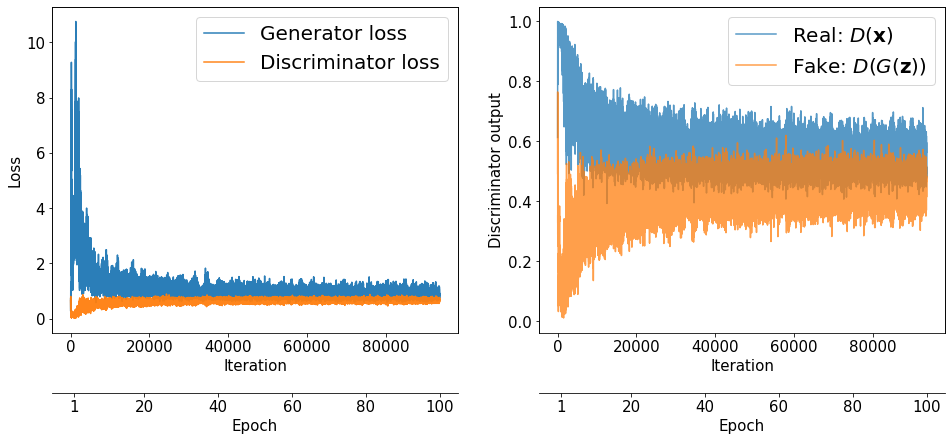

In [ ]:
import itertools

fig = plt.figure(figsize=(16, 6))

# plotting the losses
ax = fig.add_subplot(1, 2, 1)
g_losses = [item[0] for item in itertools.chain(*all_losses)]
d_losses = [item[1]/2.0 for item in itertools.chain(*all_losses)]

plt.plot(g_losses, label='Generator loss', alpha=0.95)
plt.plot(d_losses, label='Discriminator loss', alpha=0.95)
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Loss', size=15)

epochs = np.arange(1, 101)
epoch2iter = lambda e: e*len(all_losses[-1])
epoch_ticks = [1, 20, 40, 60, 80, 100]
newpos = [epoch2iter(e) for e in epoch_ticks]
ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)

# plotting the outputs of the discriminator
ax = fig.add_subplot(1, 2, 2)
d_vals_real = [item[0] for item in itertools.chain(*all_d_vals)]
d_vals_fake = [item[1] for item in itertools.chain(*all_d_vals)]
plt.plot(d_vals_real, alpha=0.75, label=r'Real: $D(\mathbf{x})$')
plt.plot(d_vals_fake, alpha=0.75, label=r'Fake: $D(G(\mathbf{z}))$')
plt.legend(fontsize=20)
ax.set_xlabel('Iteration', size=15)
ax.set_ylabel('Discriminator output', size=15)

ax2 = ax.twiny()
ax2.set_xticks(newpos)
ax2.set_xticklabels(epoch_ticks)
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward', 60))
ax2.set_xlabel('Epoch', size=15)
ax2.set_xlim(ax.get_xlim())
ax.tick_params(axis='both', which='major', labelsize=15)
ax2.tick_params(axis='both', which='major', labelsize=15)
plt.show()

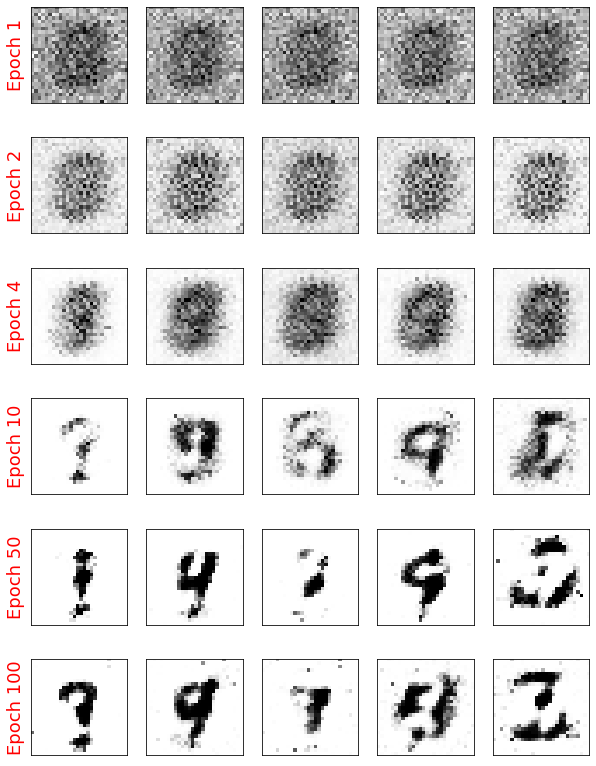

In [ ]:
selected_epochs = [1, 2, 4, 10, 50, 100]
fig = plt.figure(figsize=(10, 14))
for i,e in enumerate(selected_epochs):
  for j in range(5):
    ax = fig.add_subplot(6, 5, i*5+j+1)
    ax.set_xticks([])
    ax.set_yticks([])
    if j == 0:
      ax.text(
        -0.06, 0.5, 'Epoch {}'.format(e),
        rotation=90, size=18, color='red',
        horizontalalignment='right',
        verticalalignment='center',
        transform=ax.transAxes)
    image = epoch_samples[e-1][j]
    ax.imshow(image, cmap='gray_r')

plt.show()